# Stochastic Varitional Inference with Liesel

In this tutorial, we introduce the new variational inference (VI) module in Liesel.
We illustrate its usage with a distributional regression example where the response follows a Gamma distribution and the dataset contains a large number of observations.

The tutorial walks through:
	- building a regression model with distributional parameters;
	- defining variational distributions for latent variables;
	- setting up optimizers and running stochastic variational inference;
	- and interpreting the results through summaries and plots.

This example shows how the VI module enables flexible and efficient Bayesian inference for complex models, even when working with large datasets.

In [1]:
import jax
import jax.numpy as jnp
import liesel.model as lsl
import matplotlib.pyplot as plt
import optax
import tensorflow_probability.substrates.jax.bijectors as tfb
import seaborn as sns

from tensorflow_probability.substrates import jax as tfp
from liesel.distributions.mvn_degen import MultivariateNormalDegenerate, _log_pdet, _rank
from liesel.experimental.vi import OptimizerBuilder, LieselInterface, Summary
from jax import random, vmap
from csplines import build_design_matrix_b_spline, build_p_spline_matrix, create_equidistant_knots, center_spline

tfd = tfp.distributions

In [2]:
def softplus(x):
    return jnp.log(1. + jnp.exp(x))

## Data Generation

We generate synthetic data from a Gamma distribution parametrized by mean $\mu_i > 0$ and variance $\sigma_i^2 > 0$:

\begin{align*}
    x_i &\sim \mathcal{U}(0, 2\pi)\\
    y_i &\sim \text{Gamma}(\exp\{1.3 + 0.7 \sin(-x_i)\}, \exp\{-0.4 - 0.9 \cos(0.6 * x_i)\}^2),
\end{align*}

for $i = 1, \dots, 200$.

In [3]:
key = jax.random.PRNGKey(13)

In [4]:
N = 200

n_params = 10
order = 3
r = 2

In [5]:
key, key_data = random.split(key, 2)

key_X, key_y = random.split(key_data, 2)

x = tfd.Uniform(0., 2 * jnp.pi).sample((N, ), key_X)

knots = create_equidistant_knots(x, order, n_params)
X = build_design_matrix_b_spline(x, knots, order)
K = build_p_spline_matrix(n_params, r)
    
X, K = center_spline(X, K)

Q = X.shape[1]

y = tfd.Gamma.experimental_from_mean_variance(
    mean=jnp.exp(1.3 + 0.7 * jnp.sin(-x)),
    variance=jnp.exp(0.4 - 0.9 * jnp.cos(0.6 * x))**2
).sample(seed=key_y)

Let's give a look at the data

<Axes: >

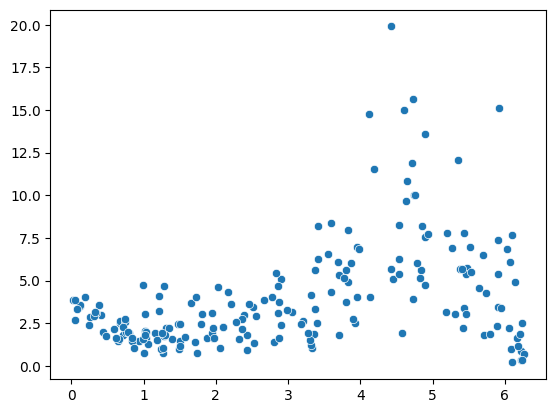

In [6]:
sns.scatterplot(x=x, y=y)

## Model building

In [7]:
evals = jax.numpy.linalg.eigvalsh(K)
rank = _rank(evals)
log_pdet = _log_pdet(evals, rank=rank)

First, we build our Liesel model as usual.

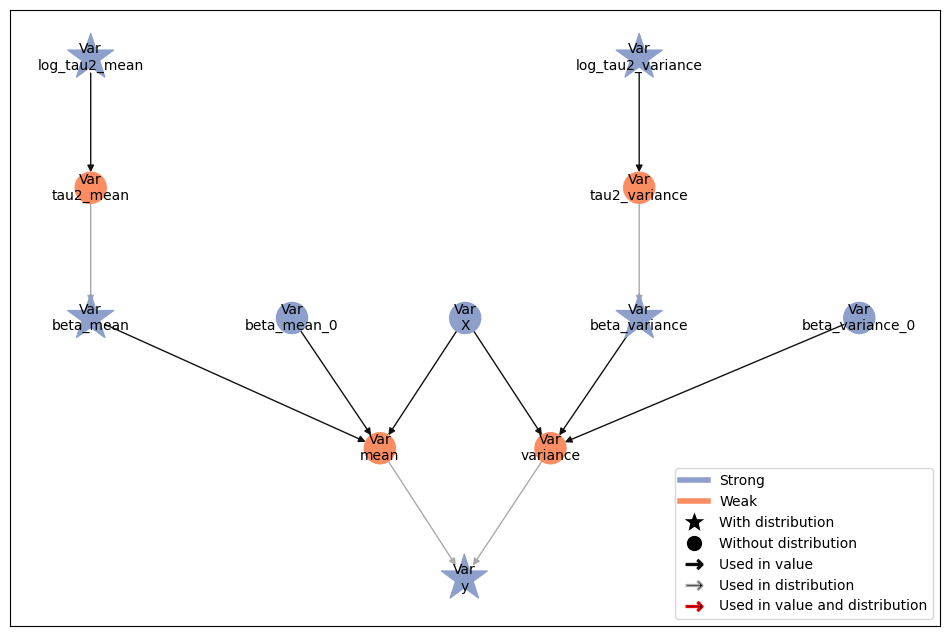

In [8]:
X = lsl.Var.new_obs(value=X, name="X")

# mean

beta_mean_0 = lsl.Var.new_param(value=0., name='beta_mean_0')

log_tau2_mean_dist = lsl.Dist(tfd.ExpGamma, concentration=1.0, rate=0.01)
log_tau2_mean = lsl.Var.new_param(value=1.0, distribution=log_tau2_mean_dist, name='log_tau2_mean')
tau2_mean = lsl.Var(lsl.Calc(jnp.exp, log_tau2_mean), name="tau2_mean")

beta_1_mean_dist = lsl.Dist(
    distribution=MultivariateNormalDegenerate.from_penalty_smooth, 
    loc=jnp.zeros(Q),
    smooth=tau2_mean, 
    pen=K,
    rank=rank,
    log_pdet=log_pdet
)
beta_mean = lsl.Var.new_param(value=jnp.zeros(Q), distribution=beta_1_mean_dist, name='beta_mean')

# variance

beta_variance_0 = lsl.Var.new_param(value=0., name='beta_variance_0')

log_tau2_variance_dist = lsl.Dist(tfd.ExpGamma, concentration=1.0, rate=0.01)
log_tau2_variance = lsl.Var.new_param(value=1.0, distribution=log_tau2_variance_dist, name='log_tau2_variance')
tau2_variance = lsl.Var(lsl.Calc(jnp.exp, log_tau2_variance), name="tau2_variance")

beta_1_variance_dist = lsl.Dist(
    distribution=MultivariateNormalDegenerate.from_penalty_smooth, 
    loc=jnp.zeros(Q),
    smooth=tau2_variance, 
    pen=K,
    rank=rank,
    log_pdet=log_pdet
)
beta_variance = lsl.Var.new_param(value=jnp.zeros(Q), distribution=beta_1_variance_dist, name='beta_variance')

# eta_fn_mean = lambda X, beta_0, beta: jnp.exp(beta_0 + X @ beta)
# eta_fn_variance = lambda X, beta_0, beta: jnp.exp(beta_0 + X @ beta)**2

eta_fn_mean = lambda X, beta_0, beta: softplus(beta_0 + X @ beta)
eta_fn_variance = lambda X, beta_0, beta: softplus(beta_0 + X @ beta)**2

mean = lsl.Var(lsl.Calc(eta_fn_mean, X, beta_mean_0, beta_mean), name="mean")
variance = lsl.Var(lsl.Calc(eta_fn_variance, X, beta_variance_0, beta_variance), name="variance")

dist_y = lsl.Dist(distribution=tfd.Gamma.experimental_from_mean_variance, mean=mean, variance=variance)
# dist_y = lsl.Dist(distribution=tfd.Normal, loc=mean, scale=variance)
y = lsl.Var.new_obs(value=y, distribution=dist_y, name="y")

gb = lsl.GraphBuilder()
gb.add(y)

model = gb.build_model()

lsl.plot_vars(model=model, width=12, height=8)

We now configure and run **variational inference (VI)** in Liesel.

- First, we create an `OptimizerBuilder` to manage VI, setting the number of epochs, batch size, seed, and early stopping.
- We link the builder to our model through the `LieselInterface`.
- Optimization chains are defined using **Optax** (gradient clipping + Adam optimizer).
- Variational distributions are added for each group of latent variables:
  - `log_tau2` parameters with Normal variational distributions.
  - `beta_mean_0`, `beta_variance_0` with normal distributions.
  - `beta_mean`, `beta_variance` with multivariate normal distributions.

Finally, we build and fit the optimizer, then extract results from the trained variational posterior.

In [9]:
# Initialize the builder.
builder = OptimizerBuilder(
    seed=13,
    n_epochs=1000,
    batch_size=None,
    S=64,
    patience_tol=0.001,
    window_size=1000,
)
# Set up the model interface.
interface = LieselInterface(model)
builder.set_model(interface)

# Define optimizer chains.
optimizer_chain_beta_mean_0 = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))
optimizer_chain_beta_mean = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))
optimizer_chain_beta_variance_0 = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))
optimizer_chain_beta_variance = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))

optimizer_chain_log_tau2_mean = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))
optimizer_chain_log_tau2_variance = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))

builder.add_variational_dist(
    ["log_tau2_mean"],
    dist_class=tfd.Normal,
    variational_params={"loc": 1.0, "scale": 1.0},
    optimizer_chain=optimizer_chain_log_tau2_mean,
    variational_param_bijectors={
        "loc": tfb.Identity(),
        "scale": tfb.Exp(),
    },
)

builder.add_variational_dist(
    ["log_tau2_variance"],
    dist_class=tfd.Normal,
    variational_params={"loc": 1.0, "scale": 1.0},
    optimizer_chain=optimizer_chain_log_tau2_variance,
    variational_param_bijectors={
        "loc": tfb.Identity(),
        "scale": tfb.Exp(),
    },
)

builder.add_variational_dist(
    ["beta_mean_0"],
    dist_class=tfd.Normal,
    variational_params={"loc": 0., "scale": 1.},
    optimizer_chain=optimizer_chain_beta_mean_0,
)
builder.add_variational_dist(
    ["beta_mean"],
    dist_class=tfd.MultivariateNormalTriL,
    variational_params={"loc": jnp.zeros(Q), "scale_tril": jnp.eye(Q)},
    optimizer_chain=optimizer_chain_beta_mean,
)
builder.add_variational_dist(
    ["beta_variance_0"],
    dist_class=tfd.Normal,
    variational_params={"loc": 0., "scale": 1.},
    optimizer_chain=optimizer_chain_beta_variance_0,
)
builder.add_variational_dist(
    ["beta_variance"],
    dist_class=tfd.MultivariateNormalTriL,
    variational_params={"loc": jnp.zeros(Q), "scale_tril": jnp.eye(Q)},
    optimizer_chain=optimizer_chain_beta_variance,
)

# Build and run the optimizer.
optimizer = builder.build()
optimizer.fit()

results = optimizer.get_results()

Epoch:   1000 — ELBO: -381.7533


In [10]:
summary = Summary(results)

Let's give a look at the ELBO history.

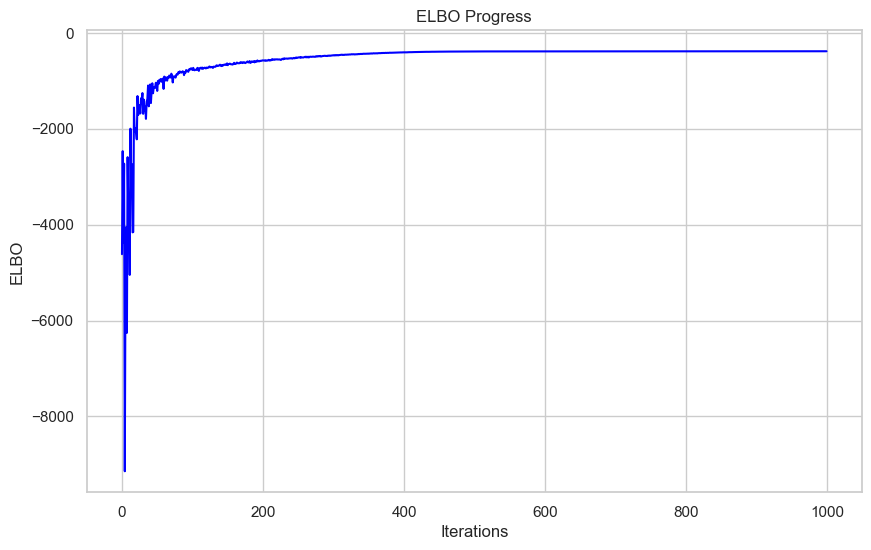

In [11]:
summary.plot_elbo()

We can also look at some summary statistics.

In [12]:
summary.compute_posterior_summary()

,variable,mean,variance,2.5%,97.5%,hdi_low,hdi_high
0,log_tau2_mean,-1.926637,0.195050,-2.787146,-1.061010,-2.641635,-1.180201
1,log_tau2_variance,3.406690,0.199202,2.531031,4.287336,2.686192,4.142302
2,beta_mean_0,3.957289,0.005098,3.816654,4.098689,3.837646,4.072783
3,beta_mean[0],-1.013675,0.373320,-2.240211,0.159360,-2.019900,-0.004391
4,beta_mean[1],-3.851533,0.519848,-5.295882,-2.450716,-5.033741,-2.648191
5,beta_mean[2],-2.684666,0.528380,-4.130083,-1.270732,-3.904152,-1.511687
6,beta_mean[3],-1.795934,0.499000,-3.200975,-0.427257,-2.944140,-0.621958
7,beta_mean[4],-0.270606,0.547258,-1.713734,1.183809,-1.504109,0.923386
8,beta_mean[5],2.986740,0.582844,1.510635,4.476986,1.787900,4.292863
9,beta_mean[6],2.224458,0.643212,0.686976,3.790682,0.927324,3.546749


In [13]:
n_samples = 100

We can use the method `final_variational_distributions` to retrieve the `tfp` variational distribution for a set of latent variables. We use that to produce 100 samples of the regression coefficients.

In [14]:
key, key_beta_mean, key_beta_variance = random.split(key, 3)
key_beta_mean_0, key_beta_mean = random.split(key_beta_mean)
key_beta_variance_0, key_beta_variance = random.split(key_beta_variance)

beta_mean_samples = jnp.c_[
    summary.final_variational_distributions['beta_mean_0'].sample(n_samples, key_beta_mean_0),
    summary.final_variational_distributions['beta_mean'].sample(n_samples, key_beta_mean)
]
beta_variance_samples = jnp.c_[
    summary.final_variational_distributions['beta_variance_0'].sample(n_samples, key_beta_variance),
    summary.final_variational_distributions['beta_variance'].sample(n_samples, key_beta_variance)
]

In [15]:
idx = jnp.argsort(x)
x_ = x[idx]
X_ = jnp.c_[jnp.ones((N, 1)), X.value[idx, :]]

Here we compare the true regression functions used to simulate the data with the posterior estimates obtained from stochastic variational inference (SVI).
- The left panel shows the estimated mean function $\mu(x)$ (blue line), together with a 95% credible band (shaded area). The true mean curve is plotted in red for reference.
- The right panel shows the estimated variance function $\sigma^2(x)$ in the same way.

[Text(0.5, 0, 'x'), Text(0, 0.5, '$\\sigma^2$')]

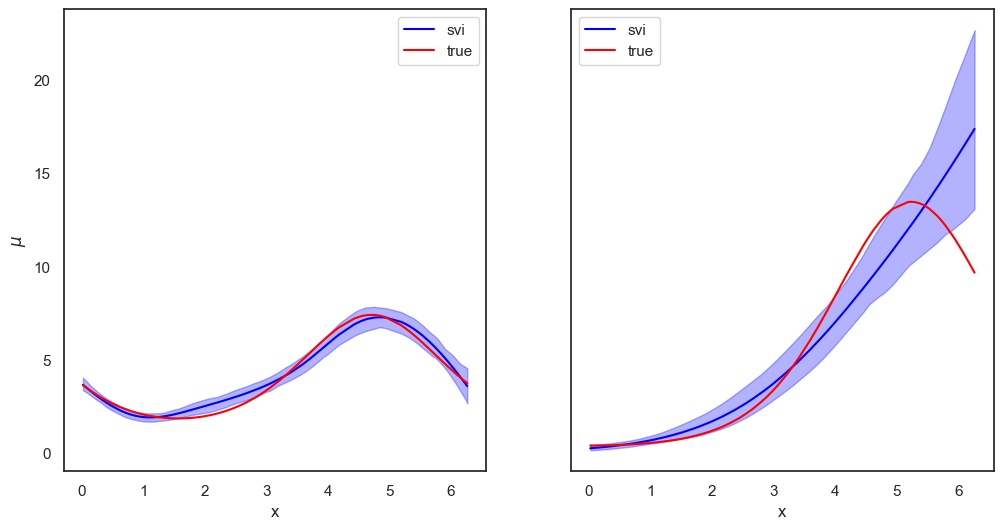

In [16]:
sns.set_theme(style="white")

fig, axes = plt.subplots(1, 2, squeeze=False, sharey=True, figsize=(12, 6))

## mean

true = jnp.exp(1.3 + 0.7 * jnp.sin(-x_))

# beta = summary.final_variational_distributions['beta_mean'].mean()[:(Q + 1)]

posterior_samples = vmap(lambda X, beta: softplus(X @ beta), (None, 0))(
    X_,
    beta_mean_samples
)
mu_hat = posterior_samples.mean(axis=0)

lower_bound = jnp.quantile(posterior_samples, 0.025, axis=0)
upper_bound = jnp.quantile(posterior_samples, 0.975, axis=0)

axes[0][0].fill_between(x_, lower_bound, upper_bound, color='blue', alpha=0.3)
sns.lineplot(x=x_, y=mu_hat, ax=axes[0][0], label='svi', color='blue')
sns.lineplot(x=x_, y=true, ax=axes[0][0], label='true', color='red')
axes[0][0].set(xlabel=f'x', ylabel=f'$\\mu$')

## variance

true = jnp.exp(0.4 - 0.9 * jnp.cos(0.6 * x_))**2

# beta = summary.final_variational_distributions['beta_variance'].mean()[(Q + 1):]

posterior_samples = vmap(lambda X, beta: softplus(X @ beta)**2, (None, 0))(
    X_,
    beta_variance_samples
)
sigma2_hat = posterior_samples.mean(axis=0)

lower_bound = jnp.quantile(posterior_samples, 0.025, axis=0)
upper_bound = jnp.quantile(posterior_samples, 0.975, axis=0)

axes[0][1].fill_between(x_, lower_bound, upper_bound, color='blue', alpha=0.3)
sns.lineplot(x=x_, y=sigma2_hat, ax=axes[0][1], label='svi', color='blue')
sns.lineplot(x=x_, y=true, ax=axes[0][1], label='true', color='red')
axes[0][1].set(xlabel=f'x', ylabel=f'$\\sigma^2$')

The choice of having one variational distribution for each grop of $\boldsymbol{\beta}$ restricts the ability of the approximation to account for correlations among parameters, since each group of coefficients is treated independently. This results in credible intervals that do not cover the true function.

An important feature of Liesel is that we can **combine several latent variables into a single variational distribution**. This makes it possible to capture **correlations between parameters**, leading to a richer and more accurate approximation of the posterior.

Let's try to have just two variational distribution for $\boldsymbol{\beta}$, one for the regression coefficients of the meand and of for thiose of the variance

In [17]:
# Initialize the builder.
builder = OptimizerBuilder(
    seed=13,
    n_epochs=1000,
    batch_size=None,
    S=64,
    patience_tol=0.001,
    window_size=1000,
)
# Set up the model interface.
interface = LieselInterface(model)
builder.set_model(interface)

# Define optimizer chains.
optimizer_chain_beta_mean = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))
optimizer_chain_beta_variance = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))

optimizer_chain_log_tau2_mean = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))
optimizer_chain_log_tau2_variance = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))

builder.add_variational_dist(
    ["log_tau2_mean"],
    dist_class=tfd.Normal,
    variational_params={"loc": 1.0, "scale": 1.0},
    optimizer_chain=optimizer_chain_log_tau2_mean,
    variational_param_bijectors={
        "loc": tfb.Identity(),
        "scale": tfb.Exp(),
    },
)

builder.add_variational_dist(
    ["log_tau2_variance"],
    dist_class=tfd.Normal,
    variational_params={"loc": 1.0, "scale": 1.0},
    optimizer_chain=optimizer_chain_log_tau2_variance,
    variational_param_bijectors={
        "loc": tfb.Identity(),
        "scale": tfb.Exp(),
    },
)

builder.add_variational_dist(
    ["beta_mean_0", "beta_mean"],
    dist_class=tfd.MultivariateNormalTriL,
    variational_params={"loc": jnp.zeros(Q + 1), "scale_tril": jnp.eye(Q + 1)},
    optimizer_chain=optimizer_chain_beta_mean,
)
builder.add_variational_dist(
    ["beta_variance_0", "beta_variance"],
    dist_class=tfd.MultivariateNormalTriL,
    variational_params={"loc": jnp.zeros(Q + 1), "scale_tril": jnp.eye(Q + 1)},
    optimizer_chain=optimizer_chain_beta_variance,
)

# Build and run the optimizer.
optimizer = builder.build()
optimizer.fit()

results = optimizer.get_results()

Epoch:   1000 — ELBO: -381.0947


In [18]:
summary = Summary(results)

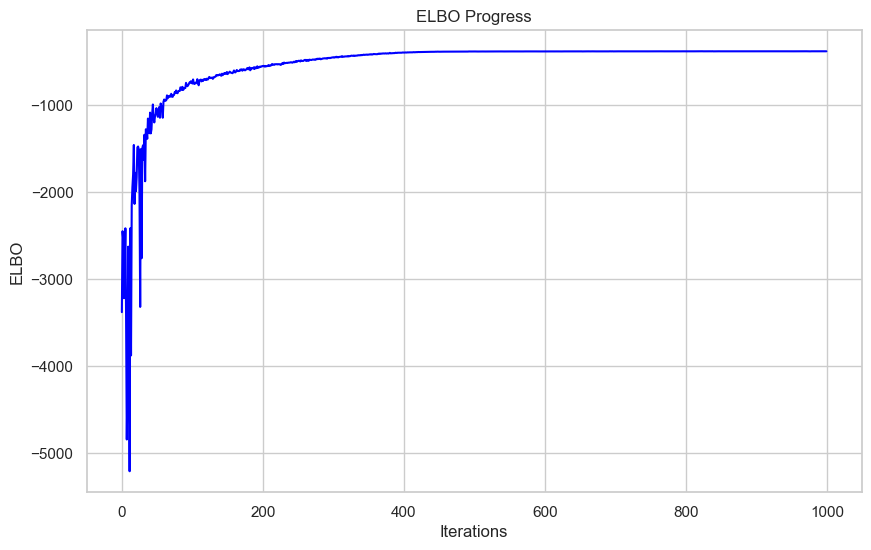

In [19]:
summary.plot_elbo()

In [20]:
key, key_beta_mean, key_beta_variance = random.split(key, 3)

beta_mean_samples = summary.final_variational_distributions['beta_mean'].sample(n_samples, key_beta_mean)
beta_variance_samples = summary.final_variational_distributions['beta_variance'].sample(n_samples, key_beta_variance)

[Text(0.5, 0, 'x'), Text(0, 0.5, '$\\sigma^2$')]

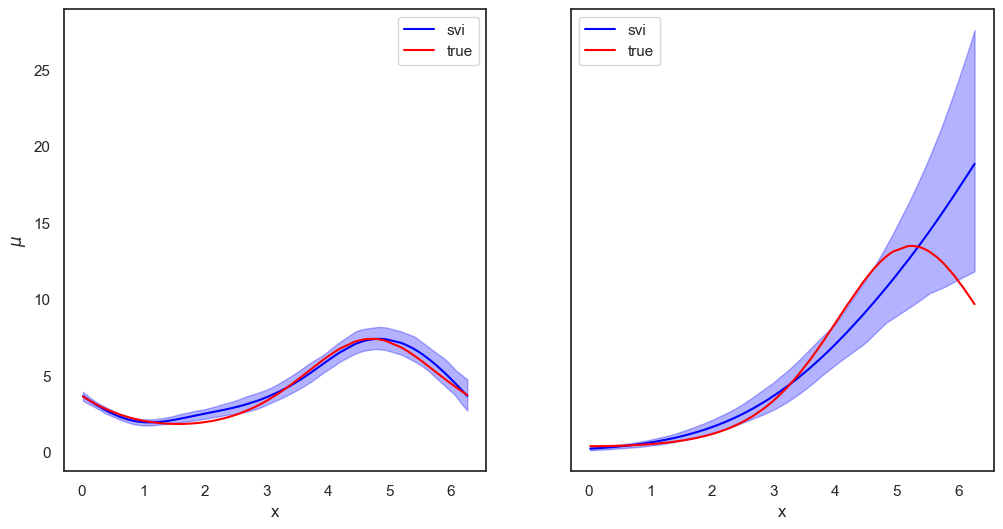

In [21]:
sns.set_theme(style="white")

fig, axes = plt.subplots(1, 2, squeeze=False, sharey=True, figsize=(12, 6))

## mean

true = jnp.exp(1.3 + 0.7 * jnp.sin(-x_))

# beta = summary.final_variational_distributions['beta_mean'].mean()[:(Q + 1)]

posterior_samples = vmap(lambda X, beta: softplus(X @ beta), (None, 0))(
    X_,
    beta_mean_samples
)
mu_hat = posterior_samples.mean(axis=0)

lower_bound = jnp.quantile(posterior_samples, 0.025, axis=0)
upper_bound = jnp.quantile(posterior_samples, 0.975, axis=0)

axes[0][0].fill_between(x_, lower_bound, upper_bound, color='blue', alpha=0.3)
sns.lineplot(x=x_, y=mu_hat, ax=axes[0][0], label='svi', color='blue')
sns.lineplot(x=x_, y=true, ax=axes[0][0], label='true', color='red')
axes[0][0].set(xlabel=f'x', ylabel=f'$\\mu$')

## variance

true = jnp.exp(0.4 - 0.9 * jnp.cos(0.6 * x_))**2

# beta = summary.final_variational_distributions['beta_variance'].mean()[(Q + 1):]

posterior_samples = vmap(lambda X, beta: softplus(X @ beta)**2, (None, 0))(
    X_,
    beta_variance_samples
)
sigma2_hat = posterior_samples.mean(axis=0)

lower_bound = jnp.quantile(posterior_samples, 0.025, axis=0)
upper_bound = jnp.quantile(posterior_samples, 0.975, axis=0)

axes[0][1].fill_between(x_, lower_bound, upper_bound, color='blue', alpha=0.3)
sns.lineplot(x=x_, y=sigma2_hat, ax=axes[0][1], label='svi', color='blue')
sns.lineplot(x=x_, y=true, ax=axes[0][1], label='true', color='red')
axes[0][1].set(xlabel=f'x', ylabel=f'$\\sigma^2$')

The results are still quite poor. Let's try to merge all $\boldsymbol{\beta}$ together.

In [22]:
# Initialize the builder.
builder = OptimizerBuilder(
    seed=13,
    n_epochs=1000,
    batch_size=None,
    S=64,
    patience_tol=0.001,
    window_size=1000,
)
# Set up the model interface.
interface = LieselInterface(model)
builder.set_model(interface)

# Define optimizer chains.
optimizer_chain_beta = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))

optimizer_chain_log_tau2_mean = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))
optimizer_chain_log_tau2_variance = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))

builder.add_variational_dist(
    ["log_tau2_mean"],
    dist_class=tfd.Normal,
    variational_params={"loc": 1.0, "scale": 1.0},
    optimizer_chain=optimizer_chain_log_tau2_mean,
    variational_param_bijectors={
        "loc": tfb.Identity(),
        "scale": tfb.Exp(),
    },
)

builder.add_variational_dist(
    ["log_tau2_variance"],
    dist_class=tfd.Normal,
    variational_params={"loc": 1.0, "scale": 1.0},
    optimizer_chain=optimizer_chain_log_tau2_variance,
    variational_param_bijectors={
        "loc": tfb.Identity(),
        "scale": tfb.Exp(),
    },
)

builder.add_variational_dist(
    ["beta_mean_0", "beta_mean", "beta_variance_0", "beta_variance"],
    dist_class=tfd.MultivariateNormalTriL,
    variational_params={"loc": jnp.zeros((Q + 1) * 2), "scale_tril": jnp.eye((Q + 1) * 2)},
    optimizer_chain=optimizer_chain_beta,
)

# Build and run the optimizer.
optimizer = builder.build()
optimizer.fit()

results = optimizer.get_results()

Epoch:   1000 — ELBO: -381.6249


In [23]:
summary = Summary(results)

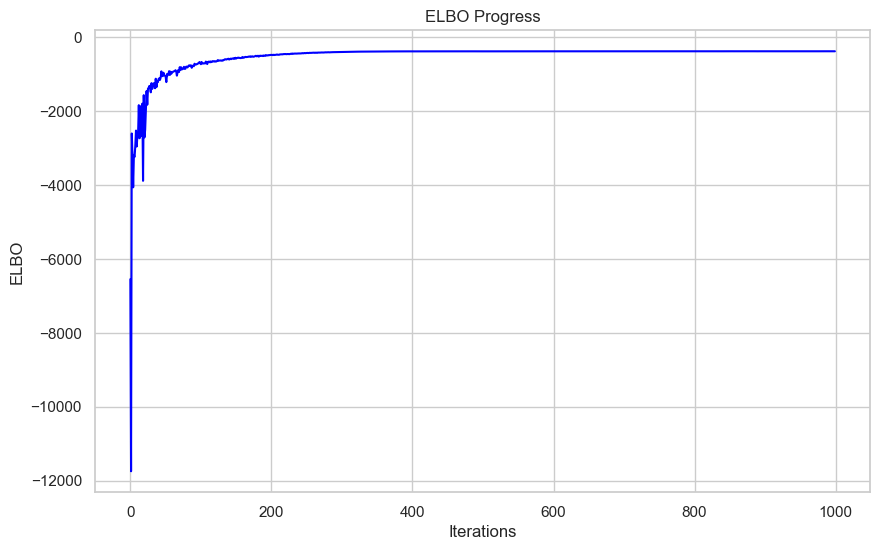

In [24]:
summary.plot_elbo()

In [25]:
beta_samples = summary.final_variational_distributions['beta_mean'].sample(n_samples, key)

beta_mean_samples = beta_samples[:, :(Q + 1)]
beta_variance_samples = beta_samples[:, (Q + 1):]

[Text(0.5, 0, 'x'), Text(0, 0.5, '$\\sigma^2$')]

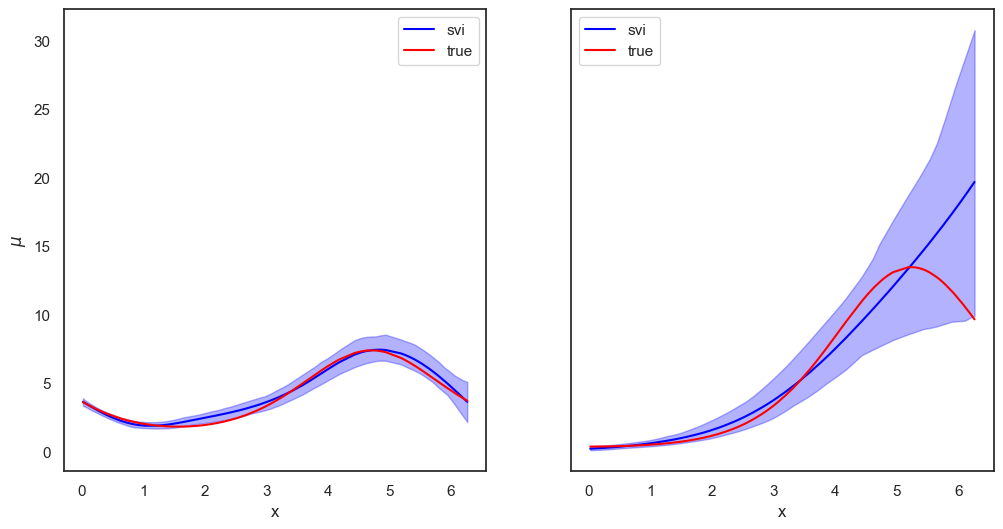

In [26]:
sns.set_theme(style="white")

fig, axes = plt.subplots(1, 2, squeeze=False, sharey=True, figsize=(12, 6))

## mean

true = jnp.exp(1.3 + 0.7 * jnp.sin(-x_))

# beta = summary.final_variational_distributions['beta_mean'].mean()[:(Q + 1)]

posterior_samples = vmap(lambda X, beta: softplus(X @ beta), (None, 0))(
    X_,
    beta_mean_samples
)
mu_hat = posterior_samples.mean(axis=0)

lower_bound = jnp.quantile(posterior_samples, 0.025, axis=0)
upper_bound = jnp.quantile(posterior_samples, 0.975, axis=0)

axes[0][0].fill_between(x_, lower_bound, upper_bound, color='blue', alpha=0.3)
sns.lineplot(x=x_, y=mu_hat, ax=axes[0][0], label='svi', color='blue')
sns.lineplot(x=x_, y=true, ax=axes[0][0], label='true', color='red')
axes[0][0].set(xlabel=f'x', ylabel=f'$\\mu$')

## variance

true = jnp.exp(0.4 - 0.9 * jnp.cos(0.6 * x_))**2

# beta = summary.final_variational_distributions['beta_variance'].mean()[(Q + 1):]

posterior_samples = vmap(lambda X, beta: softplus(X @ beta)**2, (None, 0))(
    X_,
    beta_variance_samples
)
sigma2_hat = posterior_samples.mean(axis=0)

lower_bound = jnp.quantile(posterior_samples, 0.025, axis=0)
upper_bound = jnp.quantile(posterior_samples, 0.975, axis=0)

axes[0][1].fill_between(x_, lower_bound, upper_bound, color='blue', alpha=0.3)
sns.lineplot(x=x_, y=sigma2_hat, ax=axes[0][1], label='svi', color='blue')
sns.lineplot(x=x_, y=true, ax=axes[0][1], label='true', color='red')
axes[0][1].set(xlabel=f'x', ylabel=f'$\\sigma^2$')

## SVI with a bigger model

To further illustrate the strengths of the variational inference module, we now refit the same distributional regression model on a larger dataset.
This highlights one of the main advantages of VI: its scalability and efficiency when handling complex models with many observations.

In [27]:
N = 100_000

In [28]:
key, key_data = random.split(key, 2)

key_X, key_y = random.split(key_data, 2)

x = tfd.Uniform(0., 2 * jnp.pi).sample((N, ), key_X)

knots = create_equidistant_knots(x, order, n_params)
X = build_design_matrix_b_spline(x, knots, order)
K = build_p_spline_matrix(n_params, r)
    
X, K = center_spline(X, K)

Q = X.shape[1]

y = tfd.Gamma.experimental_from_mean_variance(
    mean=jnp.exp(1.3 + 0.7 * jnp.sin(-x)),
    variance=jnp.exp(0.4 - 0.9 * jnp.cos(0.6 * x))**2
).sample(seed=key_y)

<Axes: >

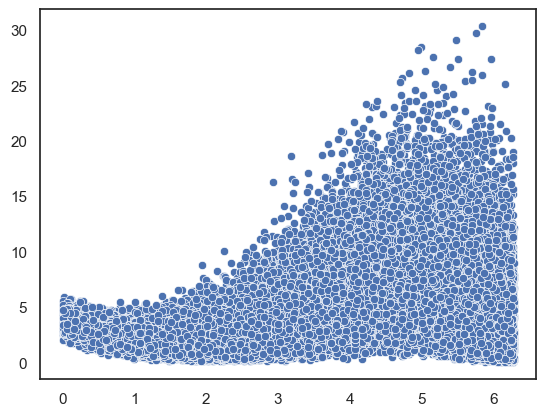

In [29]:
sns.scatterplot(x=x, y=y)

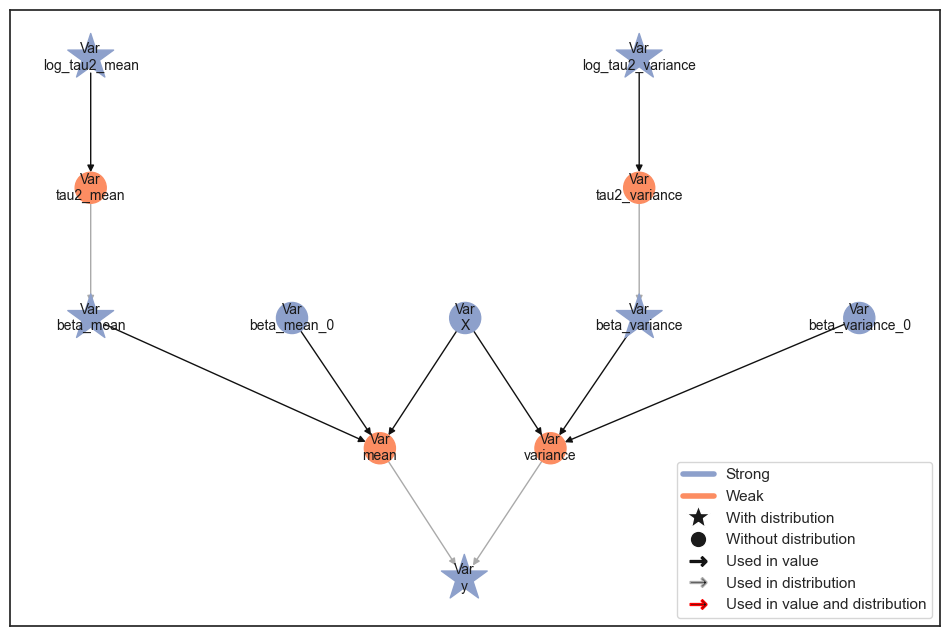

In [30]:
X = lsl.Var.new_obs(value=X, name="X")

# mean

beta_mean_0 = lsl.Var.new_param(value=0., name='beta_mean_0')

log_tau2_mean_dist = lsl.Dist(tfd.ExpGamma, concentration=1.0, rate=0.01)
log_tau2_mean = lsl.Var.new_param(value=1.0, distribution=log_tau2_mean_dist, name='log_tau2_mean')
tau2_mean = lsl.Var(lsl.Calc(jnp.exp, log_tau2_mean), name="tau2_mean")

beta_1_mean_dist = lsl.Dist(
    distribution=MultivariateNormalDegenerate.from_penalty_smooth, 
    loc=jnp.zeros(Q),
    smooth=tau2_mean, 
    pen=K,
    rank=rank,
    log_pdet=log_pdet
)
beta_mean = lsl.Var.new_param(value=jnp.zeros(Q), distribution=beta_1_mean_dist, name='beta_mean')

# variance

beta_variance_0 = lsl.Var.new_param(value=0., name='beta_variance_0')

log_tau2_variance_dist = lsl.Dist(tfd.ExpGamma, concentration=1.0, rate=0.01)
log_tau2_variance = lsl.Var.new_param(value=1.0, distribution=log_tau2_variance_dist, name='log_tau2_variance')
tau2_variance = lsl.Var(lsl.Calc(jnp.exp, log_tau2_variance), name="tau2_variance")

beta_1_variance_dist = lsl.Dist(
    distribution=MultivariateNormalDegenerate.from_penalty_smooth, 
    loc=jnp.zeros(Q),
    smooth=tau2_variance, 
    pen=K,
    rank=rank,
    log_pdet=log_pdet
)
beta_variance = lsl.Var.new_param(value=jnp.zeros(Q), distribution=beta_1_variance_dist, name='beta_variance')

# eta_fn_mean = lambda X, beta_0, beta: jnp.exp(beta_0 + X @ beta)
# eta_fn_variance = lambda X, beta_0, beta: jnp.exp(beta_0 + X @ beta)**2

eta_fn_mean = lambda X, beta_0, beta: softplus(beta_0 + X @ beta)
eta_fn_variance = lambda X, beta_0, beta: softplus(beta_0 + X @ beta)**2

mean = lsl.Var(lsl.Calc(eta_fn_mean, X, beta_mean_0, beta_mean), name="mean")
variance = lsl.Var(lsl.Calc(eta_fn_variance, X, beta_variance_0, beta_variance), name="variance")

dist_y = lsl.Dist(distribution=tfd.Gamma.experimental_from_mean_variance, mean=mean, variance=variance)
# dist_y = lsl.Dist(distribution=tfd.Normal, loc=mean, scale=variance)
y = lsl.Var.new_obs(value=y, distribution=dist_y, name="y")

gb = lsl.GraphBuilder()
gb.add(y)

model = gb.build_model()

lsl.plot_vars(model=model, width=12, height=8)

In [31]:
# Initialize the builder.
builder = OptimizerBuilder(
    seed=13,
    n_epochs=1000,
    batch_size=128,
    S=64,
    patience_tol=0.001,
    window_size=1000,
)
# Set up the model interface.
interface = LieselInterface(model)
builder.set_model(interface)

# Define optimizer chains.
optimizer_chain_beta = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))

optimizer_chain_log_tau2_mean = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))
optimizer_chain_log_tau2_variance = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=0.01))

builder.add_variational_dist(
    ["log_tau2_mean"],
    dist_class=tfd.Normal,
    variational_params={"loc": 1.0, "scale": 1.0},
    optimizer_chain=optimizer_chain_log_tau2_mean,
    variational_param_bijectors={
        "loc": tfb.Identity(),
        "scale": tfb.Exp(),
    },
)

builder.add_variational_dist(
    ["log_tau2_variance"],
    dist_class=tfd.Normal,
    variational_params={"loc": 1.0, "scale": 1.0},
    optimizer_chain=optimizer_chain_log_tau2_variance,
    variational_param_bijectors={
        "loc": tfb.Identity(),
        "scale": tfb.Exp(),
    },
)

builder.add_variational_dist(
    ["beta_mean_0", "beta_mean", "beta_variance_0", "beta_variance"],
    dist_class=tfd.MultivariateNormalTriL,
    variational_params={"loc": jnp.zeros((Q + 1) * 2), "scale_tril": jnp.eye((Q + 1) * 2)},
    optimizer_chain=optimizer_chain_beta,
)

# Build and run the optimizer.
optimizer = builder.build()
optimizer.fit()

results = optimizer.get_results()

Epoch:   1000 — ELBO: -186989.0312


In [32]:
summary = Summary(results)

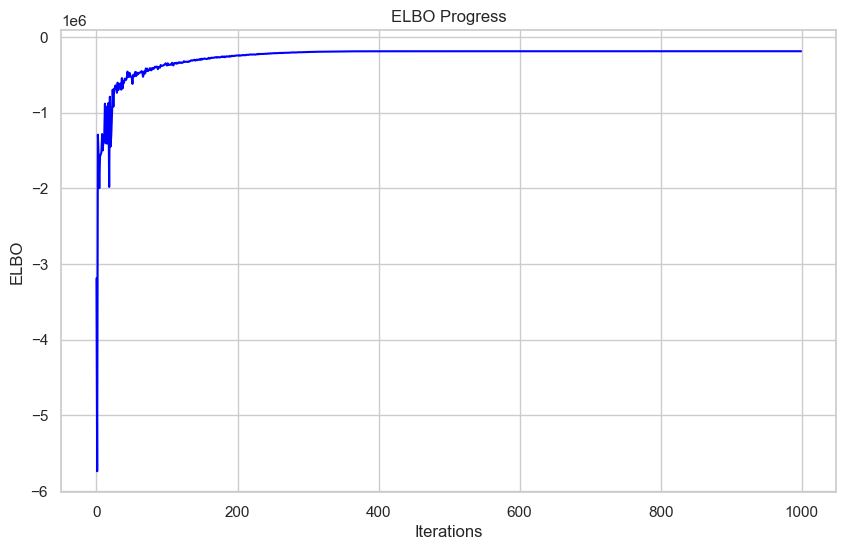

In [33]:
summary.plot_elbo()

In [34]:
idx = jnp.argsort(x)
x_ = x[idx]
X_ = jnp.c_[jnp.ones((N, 1)), X.value[idx, :]]

In [35]:
beta_samples = summary.final_variational_distributions['beta_mean'].sample(n_samples, key)

beta_mean_samples = beta_samples[:, :(Q + 1)]
beta_variance_samples = beta_samples[:, (Q + 1):]

[Text(0.5, 0, 'x'), Text(0, 0.5, '$\\sigma^2$')]

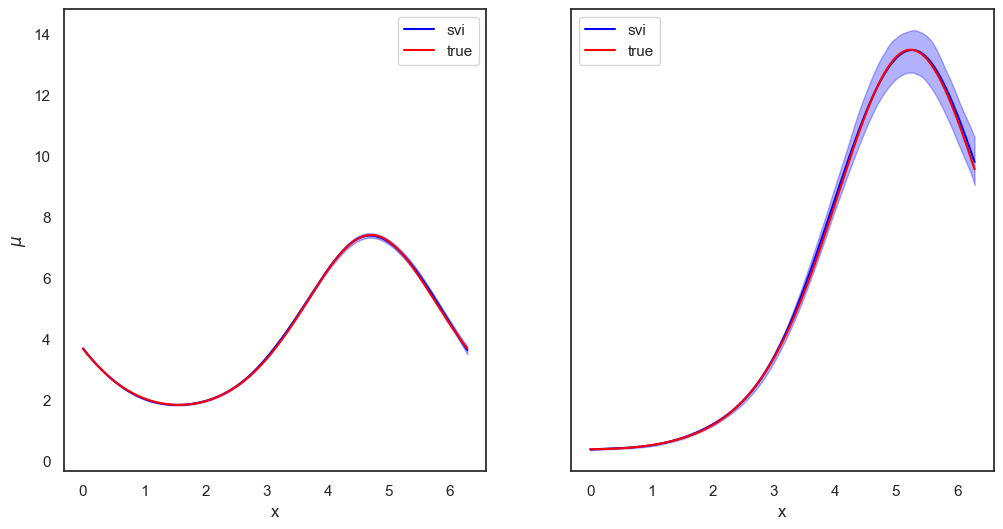

In [36]:
sns.set_theme(style="white")

fig, axes = plt.subplots(1, 2, squeeze=False, sharey=True, figsize=(12, 6))

## mean

true = jnp.exp(1.3 + 0.7 * jnp.sin(-x_))

# beta = summary.final_variational_distributions['beta_mean'].mean()[:(Q + 1)]

posterior_samples = vmap(lambda X, beta: softplus(X @ beta), (None, 0))(
    X_,
    beta_mean_samples
)
mu_hat = posterior_samples.mean(axis=0)

lower_bound = jnp.quantile(posterior_samples, 0.025, axis=0)
upper_bound = jnp.quantile(posterior_samples, 0.975, axis=0)

axes[0][0].fill_between(x_, lower_bound, upper_bound, color='blue', alpha=0.3)
sns.lineplot(x=x_, y=mu_hat, ax=axes[0][0], label='svi', color='blue')
sns.lineplot(x=x_, y=true, ax=axes[0][0], label='true', color='red')
axes[0][0].set(xlabel=f'x', ylabel=f'$\\mu$')

## variance

true = jnp.exp(0.4 - 0.9 * jnp.cos(0.6 * x_))**2

# beta = summary.final_variational_distributions['beta_variance'].mean()[(Q + 1):]

posterior_samples = vmap(lambda X, beta: softplus(X @ beta)**2, (None, 0))(
    X_,
    beta_variance_samples
)
sigma2_hat = posterior_samples.mean(axis=0)

lower_bound = jnp.quantile(posterior_samples, 0.025, axis=0)
upper_bound = jnp.quantile(posterior_samples, 0.975, axis=0)

axes[0][1].fill_between(x_, lower_bound, upper_bound, color='blue', alpha=0.3)
sns.lineplot(x=x_, y=sigma2_hat, ax=axes[0][1], label='svi', color='blue')
sns.lineplot(x=x_, y=true, ax=axes[0][1], label='true', color='red')
axes[0][1].set(xlabel=f'x', ylabel=f'$\\sigma^2$')